In [4]:
%tensorflow_version 1.x
!python3 -m pip install pydicom

TensorFlow 1.x selected.
     |████████████████████████████████| 35.5MB 88kB/s 


In [5]:
import os, random, glob2
import tqdm, json
import pydicom, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from PIL import Image

import keras
from keras.utils import plot_model, Sequence
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as keras

from albumentations import (Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop)
 
import albumentations as albu
from albumentations import Resize

Using TensorFlow backend.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Getting the Data

In [0]:
%cp -r drive/My\ Drive/Pneumothorax_Segmentation_Data_Stage1/siim-acr-pneumothorax-segmentation-data.zip ./

In [0]:
%cp -r drive/My\ Drive/Pneumothorax_Segmentation_Data_Stage1/siim-acr-pneumothorax-segmentation.zip ./

In [0]:
!unzip siim-acr-pneumothorax-segmentation-data.zip
!unzip siim-acr-pneumothorax-segmentation.zip

# Exploring the data

Originally the creators of the contest had the idea of downloading the data from Google Cloud Healthcare API, to learn a bit about accessing real-world data. Here are the instructions. Thanks for [Jesper](https://www.kaggle.com/jesperdramsch), the data is easily accessible [here](https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data)

The main folder contains two subfolders: train and test, and a csv file with the train labels. The train and test folders contain DICOM (Digital Imaging and Communications in Medicine) formatted files, for some reason every single image is embedded in two more folders.



---

## Utility functions

In [0]:
def show_dcm_info(dataset):
    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

In [0]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [0]:
STAGE1_TRAIN_SET = 'pneumothorax/dicom-images-train'
STAGE1_TEST_SET = 'pneumothorax/dicom-images-test'
STAGE2_TEST_SET = 'stage_2_images'
STAGE1_TRAIN_ANNOTATIONS = 'pneumothorax/train-rle.csv'
STAGE2_TRAIN_ANNOTATIONS = 'stage_2_train.csv'

Patient's name......: 6039ad5f-aa5b-4c3c-87e3-8136c3ecd85d, 
Patient id..........: 6039ad5f-aa5b-4c3c-87e3-8136c3ecd85d
Patient's Age.......: 54
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 151852 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]


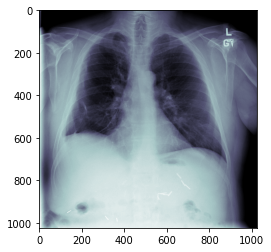

In [13]:
rand_train_dcm = ''.join(random.sample(os.listdir(STAGE1_TRAIN_SET), 1))
dicom_path = ''.join(glob2.glob(os.path.join(STAGE1_TRAIN_SET, rand_train_dcm,'*/*')))
dicom_data = pydicom.dcmread(dicom_path)
show_dcm_info(dicom_data)
plt.imshow(dicom_data.pixel_array, cmap=plt.cm.bone)

# Organizing the data

In [0]:
stage2_annotations = pd.read_csv(STAGE2_TRAIN_ANNOTATIONS)

In [15]:
stage2_annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     12954 non-null  int64 
 1   ImageId        12954 non-null  object
 2   EncodedPixels  12954 non-null  object
dtypes: int64(1), object(2)
memory usage: 303.7+ KB


In [16]:
len(set(stage2_annotations['ImageId']))

12047

In [17]:
num_stage1_test = len(os.listdir(STAGE1_TEST_SET))
num_stage1_train = len(os.listdir(STAGE1_TRAIN_SET))
num_stage1_test + num_stage1_train

12089

In [18]:
len(os.listdir(STAGE2_TEST_SET))

3205

The above cells show that the csv file contains only 12047 unique image ids but has 12954 image ids so these additional ones are either duplicates or contain additional information.

In [19]:
unique_annotations = stage2_annotations[~stage2_annotations.duplicated(subset=['ImageId'])].set_index('ImageId')['EncodedPixels']
len(unique_annotations)

12047

In [20]:
unique_annotations.index

Index(['1.2.276.0.7230010.3.1.4.8323329.3678.1517875178.953520',
       '1.2.276.0.7230010.3.1.4.8323329.4200.1517875181.692066',
       '1.2.276.0.7230010.3.1.4.8323329.4862.1517875185.159443',
       '1.2.276.0.7230010.3.1.4.8323329.12313.1517875238.510667',
       '1.2.276.0.7230010.3.1.4.8323329.14214.1517875250.261204',
       '1.2.276.0.7230010.3.1.4.8323329.2395.1517875172.526885',
       '1.2.276.0.7230010.3.1.4.8323329.3725.1517875179.163005',
       '1.2.276.0.7230010.3.1.4.8323329.5377.1517875187.826376',
       '1.2.276.0.7230010.3.1.4.8323329.4671.1517875184.56649',
       '1.2.276.0.7230010.3.1.4.8323329.3245.1517875176.864282',
       ...
       '1.2.276.0.7230010.3.1.4.8323329.3699.1517875179.40556',
       '1.2.276.0.7230010.3.1.4.8323329.32518.1517875160.978553',
       '1.2.276.0.7230010.3.1.4.8323329.12017.1517875236.916922',
       '1.2.276.0.7230010.3.1.4.8323329.6833.1517875201.453153',
       '1.2.276.0.7230010.3.1.4.8323329.2399.1517875172.536001',
       '1.2.

In [0]:
stage1_test_dcms = glob2.glob(os.path.join(STAGE1_TEST_SET,'*/*/*'))
stage1_train_dcms = glob2.glob(os.path.join(STAGE1_TRAIN_SET,'*/*/*'))
mixed_set = []
mixed_set.extend(stage1_test_dcms)
mixed_set.extend(stage1_train_dcms)
len(mixed_set)
ids = list(unique_annotations.index)
train_path = []
for dcm_file in mixed_set:
  dcm_id = dcm_file.split('/')[-1][:-4]
  if dcm_id in ids:
    train_path.append(dcm_file)
    ids.remove(dcm_id)

In [22]:
print(len(train_path), len(ids))

12047 0


In [0]:
test_path = glob2.glob(os.path.join(STAGE2_TEST_SET, '*'))

In [24]:
len(test_path)

3205

# Data Preprocessing

## Utility functions

In [0]:
def show_mask(img_path,mask_size, overlap=True):
    patient_id = img_path.split('/')[-1][:-4]
    dicom_data = pydicom.dcmread(img_path)
    image = dicom_data.pixel_array
    image = cv2.resize(image, mask_size, cv2.INTER_LINEAR)
    cv2.imwrite('test.jpg',image)
    rle = stage2_annotations.loc[stage2_annotations['ImageId'] == patient_id]['EncodedPixels'].values[0]
    if rle != '-1':
        mask = rle2mask(rle, 1024, 1024).T
        mask = cv2.resize(mask, mask_size, cv2.INTER_LINEAR)
    else :
        mask = np.zeros((mask_size))
    print(mask.shape)
    if overlap:
        plt.imshow(image, cmap=plt.cm.bone)
        plt.imshow(mask,alpha=0.5, cmap= 'Reds')
    else :
        plt.figure()
        f, axarr = plt.subplots(2,1) 
        axarr[0].imshow(image, cmap=plt.cm.bone)
        axarr[1].imshow(mask, cmap= plt.cm.bone)

In [0]:
def apply_CLAHE(img_path, img_size, clip_limit=2.0, title_gridsize= (8,8)):
    dicom_data = pydicom.dcmread(img_path)
    img = dicom_data.pixel_array
    img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=title_gridsize)
    clahe_img = clahe.apply(img)

    plt.figure()
    f, axarr = plt.subplots(2,1) 
    axarr[0].imshow(img, cmap=plt.cm.bone)#before
    axarr[0].set_title('Before CLAHE')
    axarr[1].imshow(clahe_img, cmap= plt.cm.bone)#after
    axarr[1].set_title('After CLAHE')

In [0]:
def train_val_split(train_path, split_size):
    random.shuffle(train_path)
    split_ammount = (1-split_size)*len(train_path)
    return train_path[:int(split_ammount)], train_path[int(split_ammount):]

In [0]:
def show_batch(generator, batch_number= 0, debug=False):
  '''
  Helper function to show generated batch from `DataGenerator` class
  You expected to see some images with corresponding ID and masks
  args:-
    generator: Data generator contains the labels and imgs.
    batch_number: Number that in range of the number of batches of the data generator    
  '''
  print("The number of batches for this data = ", len(generator))
  
  batch = generator.__getitem__(batch_number)
  if debug:
      ID = batch[0]
      masks = batch[2]
      imgs = batch[1]
  else:
      ID = batch_number
      imgs = batch[0]
      masks = batch[1]
  w=50
  h=50
  fig=plt.figure(figsize=(25, 25))
  columns = 8
  rows = 4
  for i in range(1, columns*rows):
    img = imgs[i]
    #img = np.squeeze(img, axis = 2)

    mask = masks[i]
    mask = np.squeeze(mask, axis = 2)

    fig.add_subplot(rows, columns, i)
    plt.title(i, fontsize = 10)
    plt.imshow(img[:,:,0], cmap=plt.cm.bone)
    plt.imshow(mask,alpha=0.5, cmap= 'Reds')
  plt.show()
  return ID

## Display masks along with the patient X-ray image

(200, 200)


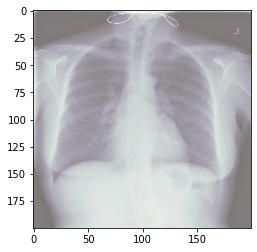

In [0]:
show_mask(train_path[50], (200,200))

(1024, 1024)


<Figure size 432x288 with 0 Axes>

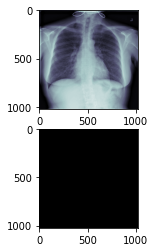

In [0]:
show_mask(train_path[50], (1024,1024),False)

(200, 200)


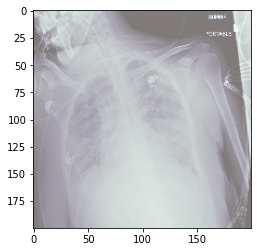

In [0]:
show_mask(train_path[500], (200,200))

(1024, 1024)


<Figure size 432x288 with 0 Axes>

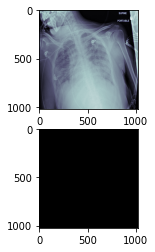

In [0]:
show_mask(train_path[500], (1024,1024),False)

## Contrast Limited Adaptive Histogram Equalization

<Figure size 432x288 with 0 Axes>

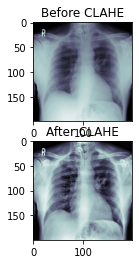

In [0]:
IMG_PATH = train_path[1]
apply_CLAHE(IMG_PATH,(200,200),clip_limit= 3.0, title_gridsize=(8,8))

<Figure size 432x288 with 0 Axes>

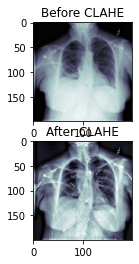

In [0]:
IMG_PATH = train_path[300]
apply_CLAHE(IMG_PATH,(200,200),clip_limit= 5.0, title_gridsize=(8,8))

# Data loader

In [0]:
class DataGenerator(Sequence):
    def __init__(self, train_data_paths, csv_datafile, batch_size=32,
                 img_size=(256,256), transform=None, debug= False, shuffle=True, n_channels = 1):
        
        self.traindata_paths = train_data_paths
        self.stage2_annotations = csv_datafile
        self.batch_size = 32 
        self.img_size = img_size 
        self.n_channels = n_channels 
        self.transform = transform 
        self.shuffle = shuffle
        self.debug = debug
        self.clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8,8))
        self.on_epoch_end()

    def on_epoch_end(self):
        '''
         Updates indexes after each epoch'''                      
        self.indexes = np.arange(len(self.traindata_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __len__(self):
        '''Denotes the number of batches per epoch
        returns:-
          number of batches per epoch'''
        return int(np.floor(len(self.traindata_paths) / self.batch_size))

    def __getitem__(self, index):
        '''Generate one batch of data 
        args:- 
            index: index of the batch   
        returns:
            imgs and masks when fitting, imgs only when predicting'''
        
        #Generate indexes of the batch    
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]    
    
        #Find the list of patientIds
        list_IDs_batch = [self.traindata_paths[k] for k in indexes]

        imgs, masks = self.__data_generation(list_IDs_batch)

        if self.transform is None:
            if self.debug:
                return list_IDs_batch, imgs/255,masks/255
            else:
                return imgs/255.0,masks/255.0
        else:
            aug_imgs,aug_masks = [],[]   
            for img,msk in zip(imgs,masks):
                augmented = self.transform(image=img, mask=msk)
                aug_imgs.append(augmented['image'])
                aug_masks.append(augmented['mask'])
            if self.debug:
                return list_IDs_batch, np.array(aug_imgs)/255, np.array(aug_masks)/255
            else:
                return np.array(aug_imgs)/255, np.array(aug_masks)/255


    def __data_generation(self, list_ID_batch):
        imgs = np.empty((self.batch_size, *self.img_size, self.n_channels))
        masks = np.empty((self.batch_size, *self.img_size, 1))

        for i, ID in enumerate(list_ID_batch):
            imgs[i,]= self.get_img(ID, self.img_size)
            masks[i,]= self.get_mask(ID, self.img_size, self.stage2_annotations)
        return imgs, masks
        

    def get_img(self, img_path, img_size):
        dicom_data = pydicom.dcmread(img_path)
        image = dicom_data.pixel_array
        img = cv2.resize(image, img_size, cv2.INTER_LINEAR)
        clahe_img = self.clahe.apply(img)
        clahe_img = np.expand_dims(clahe_img, axis=2)
        
        return clahe_img

    def get_mask(self, img_path, img_size, stage2_annotations):
        patient_id = img_path.split('/')[-1][:-4]
        rle = stage2_annotations.loc[stage2_annotations['ImageId'] == patient_id]['EncodedPixels'].values[0]
        if rle != '-1':
            mask = rle2mask(rle, 1024, 1024).T
            mask = cv2.resize(mask, img_size, cv2.INTER_LINEAR)
            mask = np.expand_dims(mask, axis=2)
        else :
            mask = np.zeros((img_size[0], img_size[1], 1))
        return mask

**Test the Dataloader class**

In [0]:
#global variables 
IMG_SIZE = (256,256)
TRAIN_PATHS = train_path
RLE_annoutations = stage2_annotations

# split the training data 
train_data, validation_data = train_val_split(TRAIN_PATHS,0.15)
print(len(train_data), len(validation_data), len(TRAIN_PATHS))

#data augmentation 
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(128, 256), height=IMG_SIZE[0], width=IMG_SIZE[1],p=0.5),
    ToFloat(max_value=1)
],p=1)
#data loaders 
training_loader = DataGenerator(train_data, RLE_annoutations, batch_size=32,
                 img_size=IMG_SIZE, transform=AUGMENTATIONS_TRAIN, debug= True)

validation_loader = DataGenerator(validation_data, RLE_annoutations, batch_size=32,
                 img_size=IMG_SIZE, transform=None, debug= True)

10239 1808 12047


**Without data augmentation**

The number of batches for this data =  319


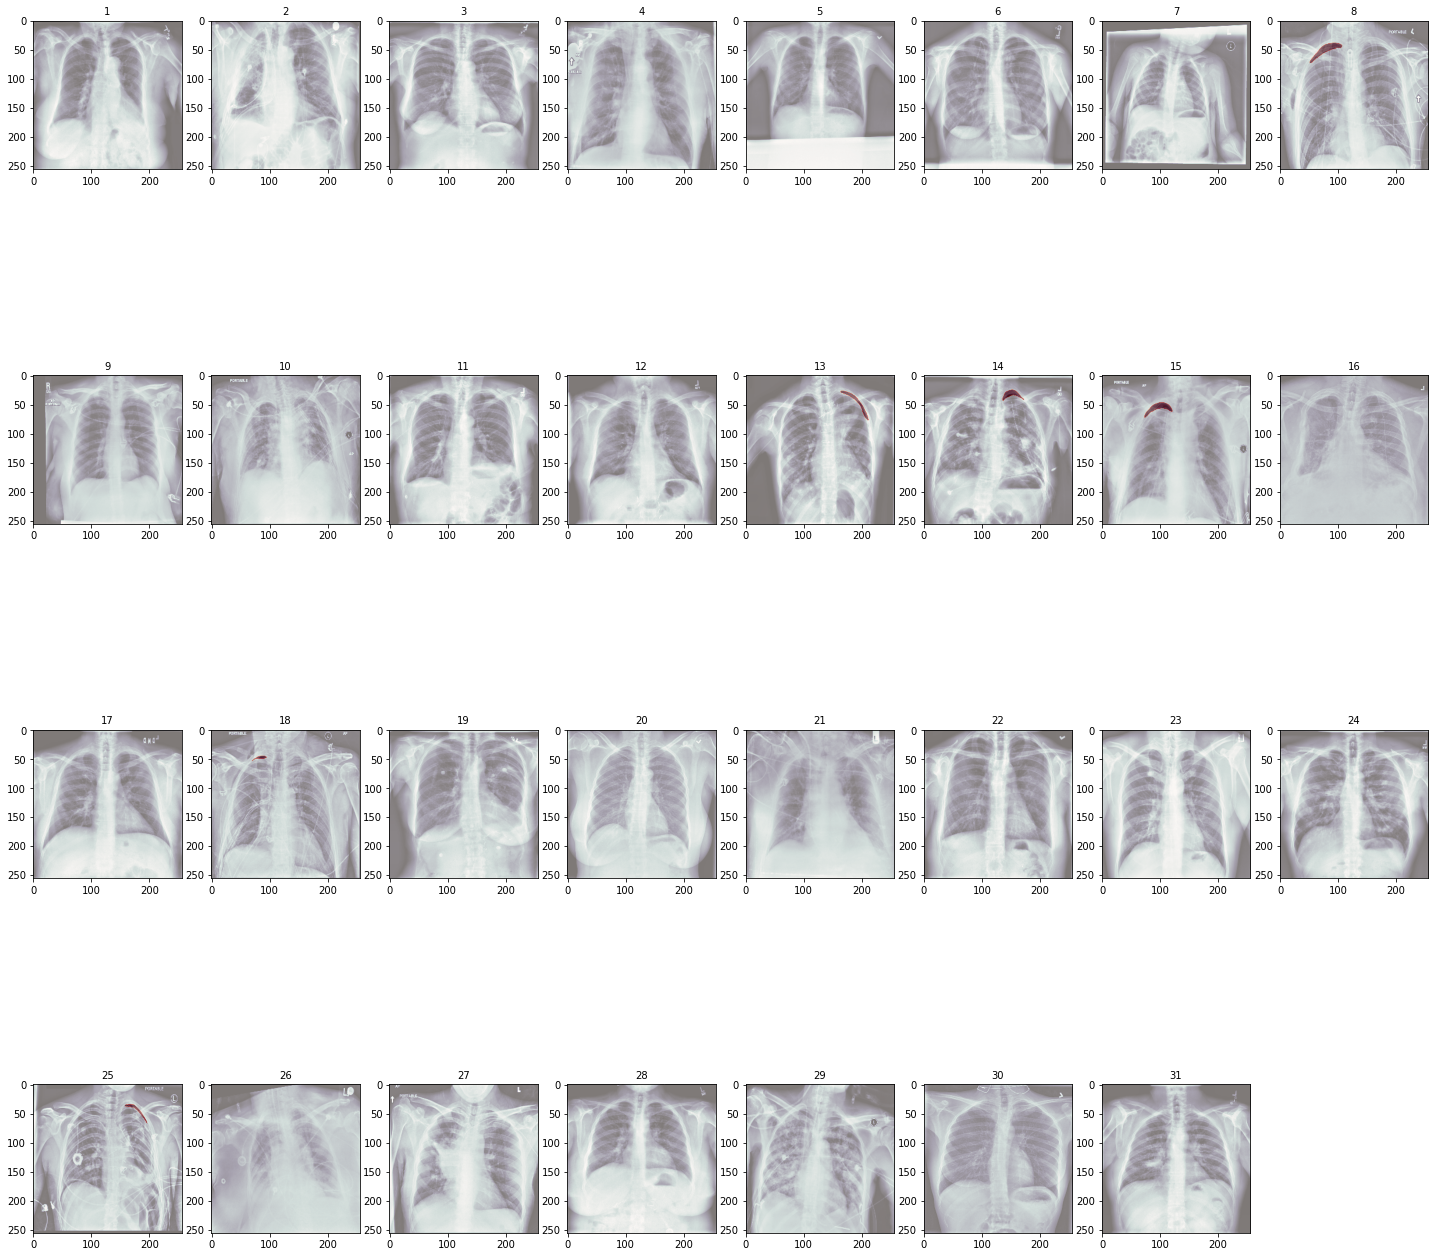

In [0]:
training_loader = DataGenerator(train_data, RLE_annoutations, batch_size=32,
                 img_size=IMG_SIZE, transform=None, debug= True)
IDs = show_batch(training_loader, 250)

**With data augmentation**

The number of batches for this data =  319
32


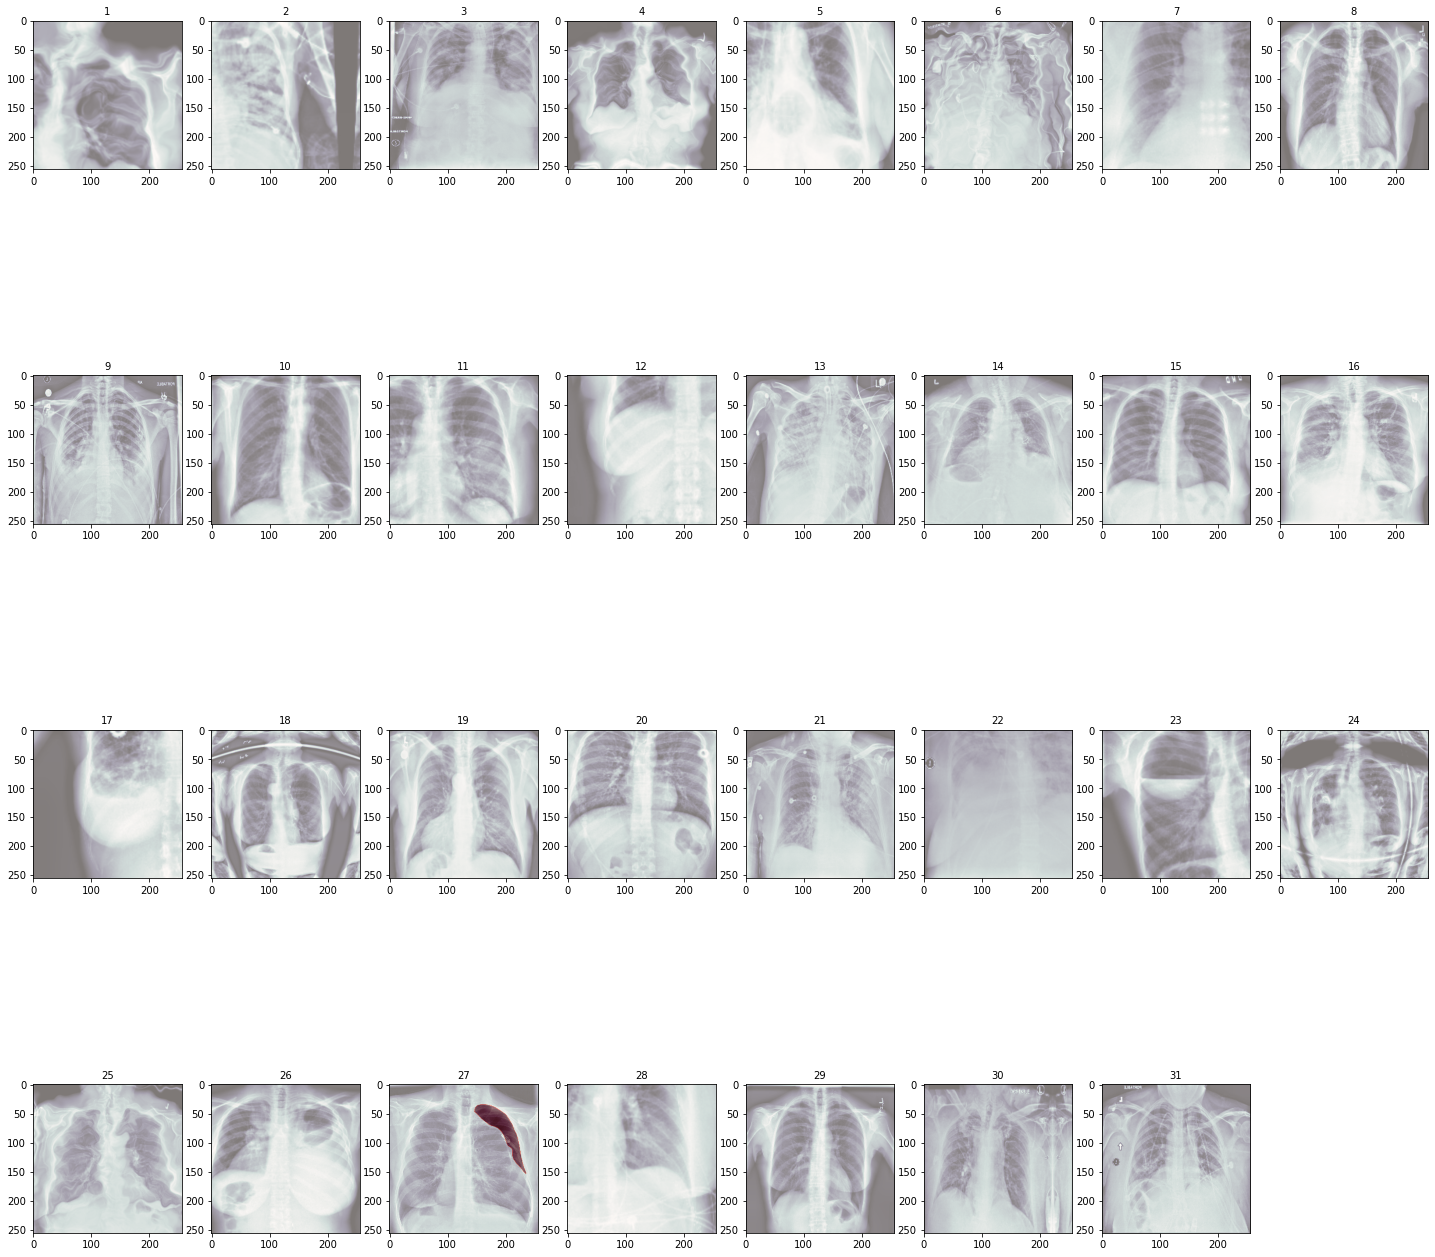

In [0]:
IDs = show_batch(training_loader, 150)

# Segmentation Model

## Metrics And Loss function

The most popular metrics for assessing the accuracy of segmentation algorithms.

***Intersection over Union (IoU)***

One of the most commonly used metrics in semantic segmentation. It is deﬁned as the area of intersection between the predicted segmentation map and the ground truth, divided by the area of union between the predicted segmentation map and the ground truth: 

![alt text](https://datasets.simula.no/kvasir-seg/images/iou.jpg)

where A and B denote the ground truth and the predicted segmentation maps, respectively. It ranges between 0 and 1.

In [0]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

***Dice coefﬁcient***

Dice coefﬁcient is another popular metric for image segmentation, which can be deﬁned as twice the overlap area of predicted and ground-truth maps, divided by the total number of pixels in both images. The Dice coefﬁcient is very similar to the IoU:

![alt text](https://gitcdn.xyz/cdn/Tony607/blog_statics/5e088805c7758be7e0317efeceaae8fcf2b47b97/images/segmentation/dice-coefficient.png)

When applied to boolean data (e.g., binary segmentation maps), and referring to the foreground as a positive class, the Dice coefﬁcient is essentially identical to the F1 score.


In [0]:
from keras.losses import *
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

## Vanilla Unet

In [0]:
K.clear_session()

In [44]:
im_hight = 256
im_width = 256
im_chan = 1
inputs = Input((im_hight, im_width, im_chan))
conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(inputs)
conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

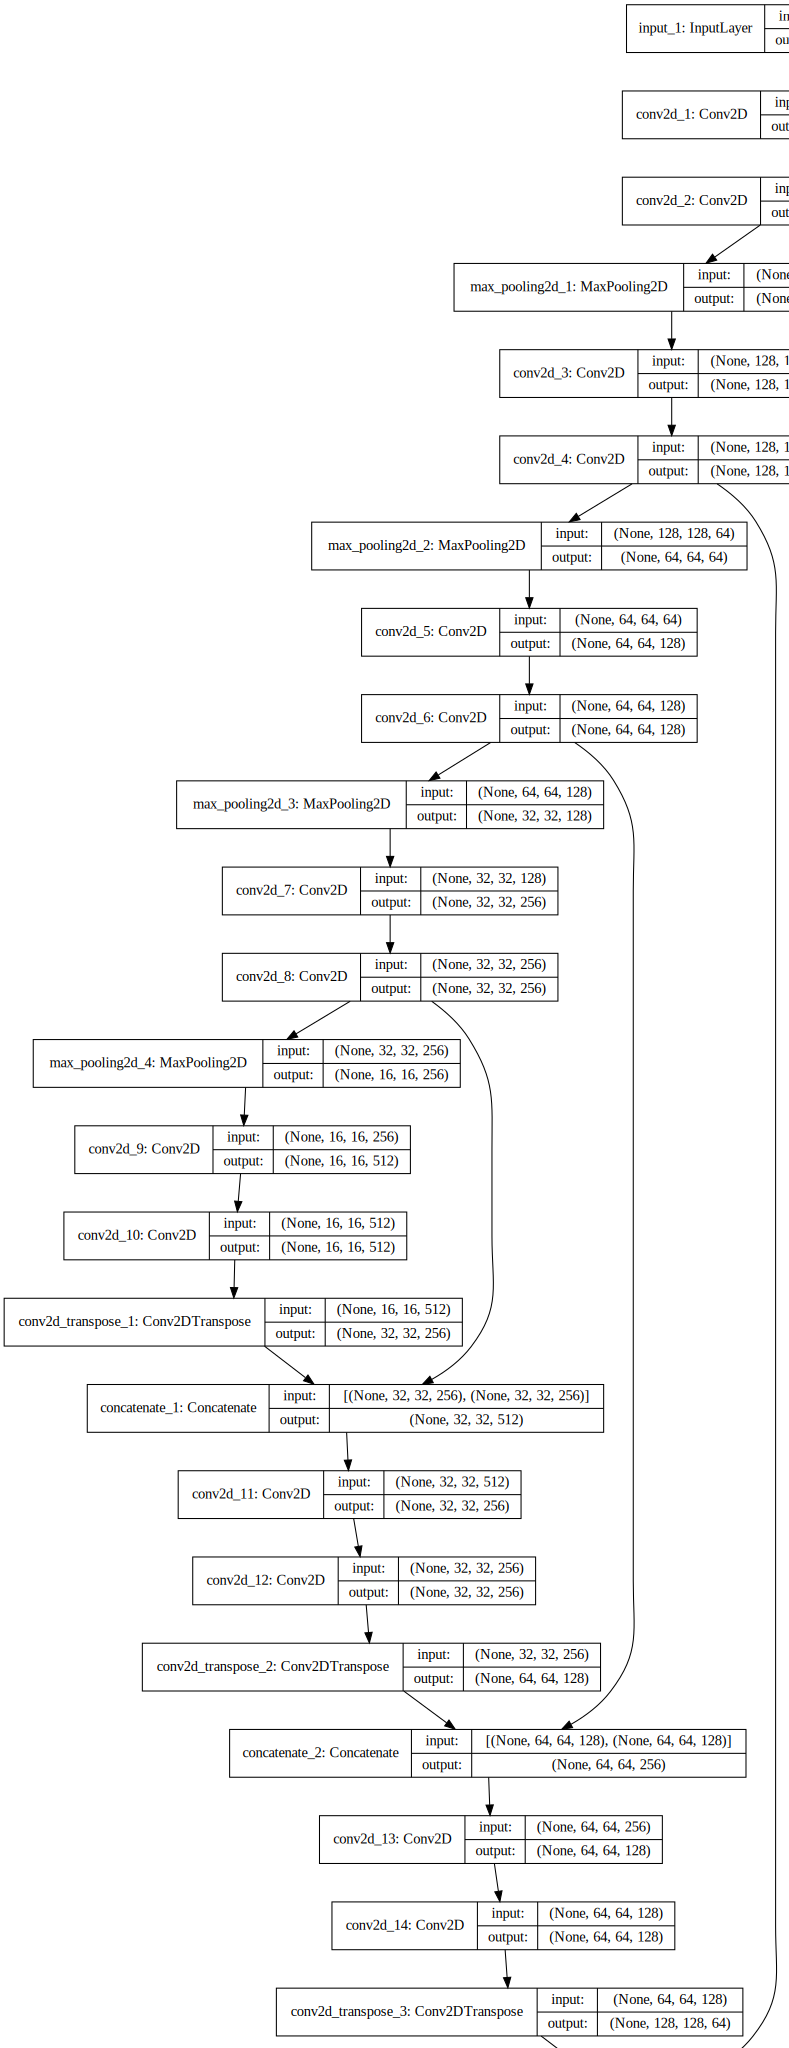

In [0]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

**Training**

In [0]:
#global variables 
IMG_SIZE = (256,256)
TRAIN_PATHS = train_path
RLE_annoutations = stage2_annotations

# split the training data 
train_data = TRAIN_PATHS
#train_data, validation_data = train_val_split(TRAIN_PATHS,0.15)
#print(len(train_data), len(validation_data), len(TRAIN_PATHS))

#data augmentation 
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(128, 256), height=IMG_SIZE[0], width=IMG_SIZE[1],p=0.5),
    ToFloat(max_value=1)
],p=1)
#data loaders 
training_loader = DataGenerator(train_data, RLE_annoutations, batch_size=32,
                 img_size=IMG_SIZE, transform=None, debug= False)

#validation_loader = DataGenerator(validation_data, RLE_annoutations, batch_size=16,
#                 img_size=IMG_SIZE, transform=None, debug= False)

In [0]:
model.compile(loss=[bce_dice_loss], optimizer='adam', metrics=[my_iou_metric])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(loss=[dice_loss], optimizer='adam', metrics=[dice_coef])

In [0]:
callback_list = [
            ModelCheckpoint("/content/drive/My Drive/Pneumothorax_Segmentatio_models/Unet/Unet_train_only.h5",monitor='loss', mode = 'min', save_best_only=True, verbose=1)
            
            #,ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
        ]

In [48]:
history = model.fit_generator(training_loader,
                    steps_per_epoch=500,
                    epochs=25,
                    callbacks=callback_list)

#validation_data=validation_loader
#validation_steps=500,


Epoch 1/25
500/500 [==============================] - 552s 1s/step - loss: 1.0118 - my_iou_metric: 0.5393

Epoch 00001: loss improved from inf to 1.01180, saving model to /content/drive/My Drive/Pneumothorax_Segmentatio_models/Unet/Unet_train_only.h5
Epoch 2/25
500/500 [==============================] - 544s 1s/step - loss: 0.9652 - my_iou_metric: 0.1216

Epoch 00002: loss improved from 1.01180 to 0.96517, saving model to /content/drive/My Drive/Pneumothorax_Segmentatio_models/Unet/Unet_train_only.h5
Epoch 3/25
500/500 [==============================] - 541s 1s/step - loss: 0.9415 - my_iou_metric: 0.2073

Epoch 00003: loss improved from 0.96517 to 0.94154, saving model to /content/drive/My Drive/Pneumothorax_Segmentatio_models/Unet/Unet_train_only.h5
Epoch 4/25
500/500 [==============================] - 540s 1s/step - loss: 0.9304 - my_iou_metric: 0.2817

Epoch 00004: loss improved from 0.94154 to 0.93040, saving model to /content/drive/My Drive/Pneumothorax_Segmentatio_models/Unet/Une